In [1]:
import os
cwd = os.getcwd()
jaxqualin_path = os.path.join(cwd, os.pardir, os.pardir)

In [2]:
import sys
sys.path.insert(0, jaxqualin_path)

In [3]:
import jaxqualin.postprocess
import jaxqualin.plot
import jaxqualin.qnmode

from jaxqualin.postprocess import *
from jaxqualin.plot import *
from jaxqualin.qnmode import *

In [4]:
from importlib import reload

In [5]:
reload(jaxqualin.postprocess)
from jaxqualin.postprocess import *
reload(jaxqualin.plot)
from jaxqualin.plot import *
reload(jaxqualin.qnmode) 
from jaxqualin.qnmode import *

In [6]:
# from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np


In [7]:
import sys
import os

In [8]:
# os.environ["PATH"] = "/home/mcheung1/julia-1.9.0/bin"+ os.pathsep + os.environ["PATH"]
os.environ["PATH"] = "/usr/local/texlive/2024/bin/x86_64-linux/" + os.environ["PATH"]

In [9]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [10]:
settingname = "normal2"

ROOT_PATH = jaxqualin_path
PLOT_PATH = os.path.join(ROOT_PATH, f"plots/{settingname}/")
PLOT_PATH_ROOT = os.path.join(ROOT_PATH, f"plots/")

In [11]:
runname = "normal2_prodB1"
runname_validation = "normal2_prodB3"

df = pd.read_csv(f"../../pickle/data_frame/{runname}_physical.csv")
df = classify_modes(df)
df = df_change_retro_to_pro(df)

In [12]:
df_validation = pd.read_csv(f"../../pickle/data_frame/{runname_validation}_physical.csv")
df_validation = classify_modes(df_validation)
df_validation = df_change_retro_to_pro(df_validation)

In [13]:
df_full = pd.concat([df, df_validation])

In [14]:
def adjust_phi(row, df):
    phi_med = row['phi_med']
    SXS_num = row['SXS_num']
    retro = row['retro']
    mode_string = row['mode_string']
    if mode_string == 'constant':
        return phi_med
    m = int(mode_string.split('.')[1])
    row_220 = df[(df['SXS_num'] == SXS_num)&(df['l'] == 2)&(df['m'] == 2)&(df['mode_string'] == '2.2.0')]
    phi_220 = row_220['phi_med'].values[0]
    retro_fac = -1 if retro else 1
    return 2*phi_med - phi_220*np.abs(m)

In [15]:
phi_med_adj_col_full = df_full.apply(lambda row: adjust_phi(row, df_full), axis=1)
df_full['phi_med_adj'] = phi_med_adj_col_full % (2*np.pi)

In [16]:
phi_med_adj_col = df.apply(lambda row: adjust_phi(row, df), axis=1)
df['phi_med_adj'] = phi_med_adj_col % (2*np.pi)

In [17]:
# PN_dom_func = {
#     (2,2): lambda eta: eta,
#     (2,1): lambda eta: eta*np.sqrt(1 - 4*eta),
#     (3,3): lambda eta: eta*np.sqrt(1 - 4*eta),
#     (3,2): lambda eta: eta*(1 - 3*eta),
#     (3,1): lambda eta: eta*np.sqrt(1 - 4*eta),
#     (4,4): lambda eta: eta*(1 - 3*eta),
#     (4,3): lambda eta: eta*np.sqrt(1 - 4*eta)*(1 - 2*eta),
#     (4,2): lambda eta: eta*(1 - 3*eta),
#     (4,1): lambda eta: eta*np.sqrt(1 - 4*eta)*(1 - 2*eta),
#     (5,5): lambda eta: eta*np.sqrt(1 - 4*eta)*(1 - 2*eta),
#     (6,6): lambda eta: eta*(1 - 5*eta + 5*eta**2),
#     (7,7): lambda eta: eta*np.sqrt(1 - 4*eta)*(1 - 4*eta + 3*eta**2),
#     (8,8): lambda eta: eta*(1 - 7*eta + 14*eta**2 - 7*eta**3),
# }

# dom_func_tex_string = {
#     (2,2): r"$\eta$",
#     (2,1): r"$\eta\sqrt{1 - 4\eta}$",
#     (3,3): r"$\eta\sqrt{1 - 4\eta}$",
#     (3,2): r"$\eta(1 - 3\eta)$",
#     (3,1): r"$\eta\sqrt{1 - 4\eta}$",
#     (4,4): r"$\eta(1 - 3\eta)$",
#     (4,3): r"$\eta\sqrt{1 - 4\eta}(1 - 2\eta)$",
#     (4,2): r"$\eta(1 - 3\eta)$",
#     (4,1): r"$\eta\sqrt{1 - 4\eta}(1 - 2\eta)$",
#     (5,5): r"$\eta\sqrt{1 - 4\eta}(1 - 2\eta)$",
#     (6,6): r"$\eta(1 - 5\eta + 5\eta^2)$",
#     (7,7): r"$\eta\sqrt{1 - 4\eta}(1 - 4\eta + 3\eta^2)$",
#     (8,8): r"$\eta(1 - 7\eta + 14\eta^2 - 7\eta^3)$",
# }

all_lm = [(2,2),(2,1),(3,3),(3,2),(3,1),(4,4),(4,3),(4,2),(4,1),(5,5),(6,6),(7,7),(8,8)]
zero_at_equal_mass_ratio = []#[(2,1),(3,3),(3,1),(4,3),(4,1),(5,5),(7,7)]

PN_dom_func = {}

for lm in all_lm:
    if lm in zero_at_equal_mass_ratio:
        PN_dom_func[lm] = lambda eta: eta*np.sqrt(1 - 4*eta)
    else:
        PN_dom_func[lm] = lambda eta: eta

In [642]:
l, m = 5, 5
mode_string_pro = '5.5.0'
mode_string_plot = mode_string_pro.replace('.', ',')
mode_string_plot_tex = mode_string_pro.replace('.', r'{,}')
if mode_string_plot[0] == '-':
    mode_string_plot = '𝑟' + mode_string_plot[1:]
    mode_string_plot_tex = r'r' + mode_string_plot_tex[1:]
    PN_func = PN_dom_func[(l,m)]
else:
    PN_func = PN_dom_func[(l,m)]

# screen = [1110]
if mode_string_pro == '5.5.0':
    screen = [110, 40]
else:
    screen = []
df_mode_3D = df_get_mode_3D_full(df, l, m, mode_string_pro, SXS_screen = screen, chi_low = 0.1, include_retro = False)
df_mode_3D = df_mode_3D.dropna()
# df_mode_3D = df_mode_3D[df_mode_3D['SXS_num'] > 305]
df_mode_3D['A_med_adj'] = df_mode_3D['A_med'] / PN_func(df_mode_3D['eta'])
df_mode_3D['A_med_adj_temp'] = df_mode_3D['A_med'] / PN_func(df_mode_3D['eta'])
df_mode_3D['A_med_log'] = np.log10(df_mode_3D['A_med'])
df_mode_3D['A_comp'] = df_mode_3D['A_med_adj'] #* np.exp(1j*df_mode_3D['phi_med_adj'])
df_mode_3D['A_comp_unadj'] = df_mode_3D['A_med'] #* np.exp(1j*df_mode_3D['phi_med_adj'])
df_mode_3D['A_real'] = np.real(df_mode_3D['A_comp'])
df_mode_3D['A_imag'] = np.imag(df_mode_3D['A_comp'])
df_mode_3D['A_range'] = np.abs(df_mode_3D['A_hi'] - df_mode_3D['A_low'])/df_mode_3D['A_med']
df_mode_3D['A_range_inv'] = 1/df_mode_3D['A_range']
df_mode_3D['A_range_adj_inv'] = PN_func(df_mode_3D['eta'])*df_mode_3D['A_range_inv']
df_mode_3D['A_range_rel_inv'] = df_mode_3D['A_med']*df_mode_3D['A_range_inv']
df_mode_3D['phi_range'] = np.abs(df_mode_3D['phi_hi'] - df_mode_3D['phi_low'])
df_mode_3D['phi_range_inv'] = 1/df_mode_3D['phi_range']
df_mode_3D['A_range_adj_abs'] = np.sqrt((np.abs(df_mode_3D['A_hi'] - df_mode_3D['A_low']))**2 + (df_mode_3D['A_med']*(df_mode_3D['phi_hi'] - df_mode_3D['phi_low']))**2) / PN_func(df_mode_3D['eta']) /2
df_mode_3D['A_range_adj_abs_inv'] = 1/df_mode_3D['A_range_adj_abs']
df_mode_3D['A_range_adj_abs_rel_inv'] = df_mode_3D['A_med_adj']*df_mode_3D['A_range_adj_abs_inv']
df_mode_3D['A_range_abs'] = df_mode_3D['A_range_adj_abs'] * PN_func(df_mode_3D['eta'])
df_mode_3D['A_range_abs_inv'] = 1/df_mode_3D['A_range_abs']
df_mode_3D['chi_p_orb'] = np.where(df_mode_3D['retro'], -df_mode_3D['chi_p'], df_mode_3D['chi_p'])
df_mode_3D['chi_m_orb'] = np.where(df_mode_3D['retro'], -df_mode_3D['chi_m'], df_mode_3D['chi_m'])

In [643]:
df_mode_3D_full = df_get_mode_3D_full(df_full, l, m, mode_string_pro, SXS_screen = screen, chi_low = 0.1, include_retro = False)
df_mode_3D_full = df_mode_3D_full.dropna()
df_mode_3D_full['A_med_adj'] = df_mode_3D_full['A_med'] / PN_func(df_mode_3D_full['eta'])
df_mode_3D_full['A_med_adj_temp'] = df_mode_3D_full['A_med'] / PN_func(df_mode_3D_full['eta'])
df_mode_3D_full['A_med_log'] = np.log10(df_mode_3D_full['A_med'])
df_mode_3D_full['A_comp'] = df_mode_3D_full['A_med_adj'] * np.exp(1j*df_mode_3D_full['phi_med_adj'])
df_mode_3D_full['A_comp_unadj'] = df_mode_3D_full['A_med'] * np.exp(1j*df_mode_3D_full['phi_med_adj'])
df_mode_3D_full['A_real'] = np.real(df_mode_3D_full['A_comp'])
df_mode_3D_full['A_imag'] = np.imag(df_mode_3D_full['A_comp'])
df_mode_3D_full['A_range'] = np.abs(df_mode_3D_full['A_hi'] - df_mode_3D_full['A_low'])/df_mode_3D_full['A_med']
df_mode_3D_full['A_range_inv'] = 1/df_mode_3D_full['A_range']
df_mode_3D_full['A_range_adj_inv'] = PN_func(df_mode_3D_full['eta'])*df_mode_3D_full['A_range_inv']
df_mode_3D_full['A_range_rel_inv'] = df_mode_3D_full['A_med']*df_mode_3D_full['A_range_inv']
df_mode_3D_full['phi_range'] = np.abs(df_mode_3D_full['phi_hi'] - df_mode_3D_full['phi_low'])
df_mode_3D_full['phi_range_inv'] = 1/df_mode_3D_full['phi_range']
df_mode_3D_full['A_range_adj_abs'] = np.sqrt((np.abs(df_mode_3D_full['A_hi'] - df_mode_3D_full['A_low']))**2 + (df_mode_3D_full['A_med']*(df_mode_3D_full['phi_hi'] - df_mode_3D_full['phi_low']))**2) / PN_func(df_mode_3D_full['eta']) /2
df_mode_3D_full['A_range_adj_abs_inv'] = 1/df_mode_3D_full['A_range_adj_abs']
df_mode_3D_full['A_range_adj_abs_rel_inv'] = df_mode_3D_full['A_med_adj']*df_mode_3D_full['A_range_adj_abs_inv']
df_mode_3D_full['A_range_abs'] = df_mode_3D_full['A_range_adj_abs'] * PN_func(df_mode_3D_full['eta'])
df_mode_3D_full['A_range_abs_inv'] = 1/df_mode_3D_full['A_range_abs']
df_mode_3D_full['chi_p_orb'] = np.where(df_mode_3D_full['retro'], -df_mode_3D_full['chi_p'], df_mode_3D_full['chi_p'])
df_mode_3D_full['chi_m_orb'] = np.where(df_mode_3D_full['retro'], -df_mode_3D_full['chi_m'], df_mode_3D_full['chi_m'])


df_mode_3D_full_full = df_mode_3D_full.copy()
df_mode_3D_full = df_mode_3D_full[
    (~((df_mode_3D_full['SXS_num'] >= 209) & (df_mode_3D_full['SXS_num'] <= 305))) & 
    (~((df_mode_3D_full['SXS_num'] >= 1419) & (df_mode_3D_full['SXS_num'] <= 1509)))]

In [644]:
# equal_mass_ratio_tol = 0.24

# if mode_string_pro in ['2.1.0', '3.3.0', '5.5.0']:
#     df_mode_3D = df_mode_3D[df_mode_3D['eta'] < equal_mass_ratio_tol]
#     df_mode_3D_full = df_mode_3D_full[df_mode_3D_full['eta'] < equal_mass_ratio_tol]
# # if mode_string_pro == '4.4.0':
# #     df_mode_3D = df_mode_3D[df_mode_3D['eta'] < 0.225]
# #     df_mode_3D_full = df_mode_3D_full[df_mode_3D_full['eta'] < 0.225]

In [645]:
df_mode_3D_full.sort_values('A_med')[-10:]

,SXS_num,chi_p,chi_m,eta,chi_1_z,chi_2_z,q,A_med,A_low,A_hi,...,A_range_rel_inv,phi_range,phi_range_inv,A_range_adj_abs,A_range_adj_abs_inv,A_range_adj_abs_rel_inv,A_range_abs,A_range_abs_inv,chi_p_orb,chi_m_orb
1147,185,1.034079e-05,1.295036e-05,0.082716,1.281136e-05,-1.433890e-05,9.989509,0.027704,0.027510,0.027840,...,2.328231,0.040360,24.777268,0.007046,141.914907,47.531745,0.000583,1715.696390,1.034079e-05,1.295036e-05
1647,199,-4.403107e-06,2.406768e-06,0.092223,-1.112523e-06,-3.312586e-05,8.728771,0.028307,0.028235,0.028340,...,7.625087,0.021466,46.586148,0.003343,299.111940,91.809436,0.000308,3243.370772,-4.403107e-06,2.406768e-06
765,166,4.547959e-07,3.213112e-07,0.122449,4.527294e-07,4.671948e-07,5.999979,0.028444,0.028435,0.028453,...,45.087833,0.007705,129.787988,0.000898,1113.727284,258.710230,0.000110,9095.416381,4.547959e-07,3.213112e-07
131,14,-2.997661e-01,-2.997663e-01,0.239978,-4.995200e-01,2.169143e-07,1.500679,0.028684,0.027617,0.029171,...,0.529366,0.308377,3.242788,0.018712,53.442097,6.387718,0.004490,222.695561,-2.997661e-01,-2.997663e-01
113,13,2.997688e-01,2.997686e-01,0.239978,4.995240e-01,2.350417e-07,1.500680,0.028893,0.027609,0.029909,...,0.362903,0.281069,3.557844,0.017586,56.862950,6.846312,0.004220,236.950434,2.997688e-01,2.997686e-01
7378,2014,7.201018e-01,5.601172e-01,0.160002,8.001397e-01,3.999558e-01,3.999930,0.029954,0.029815,0.030070,...,3.511041,0.001898,526.767752,0.000818,1222.361524,228.835467,0.000131,7639.679409,7.201018e-01,5.601172e-01
81,9,2.997626e-01,2.997623e-01,0.239978,4.995129e-01,4.110853e-07,1.500684,0.030046,0.029512,0.031847,...,0.386632,0.197627,5.060029,0.013294,75.222717,9.418083,0.003190,313.456602,2.997626e-01,2.997623e-01
401,55,3.091726e-07,1.855604e-07,0.138889,2.968399e-07,3.708357e-07,4.999987,0.032861,0.030977,0.034260,...,0.328897,0.126966,7.876131,0.019113,52.321336,12.379042,0.002655,376.712950,3.091726e-07,1.855604e-07
1787,204,3.498908e-01,3.498910e-01,0.109361,3.998670e-01,-6.864840e-07,7.001168,0.034399,0.034183,0.034539,...,3.323282,0.007719,129.548970,0.002031,492.423303,154.890782,0.000222,4502.719246,3.498908e-01,3.498910e-01
251,38,-3.746963e-01,-3.746966e-01,0.187459,-4.995400e-01,5.567843e-07,3.001328,0.040169,0.037777,0.040833,...,0.527829,0.244125,4.096266,0.027397,36.500469,7.821316,0.005136,194.712243,-3.746963e-01,-3.746966e-01


In [646]:
def phase_push(phase, theta):
    return (phase + theta)%(2*np.pi)

In [647]:
def unwrap_crude(df, phase, eta_cut, theta, thresh = np.pi, up = True, reverse = False, push = True, SXS_minus = [], SXS_plus = []):
    if push:
        phase_pushed = phase_push(phase, theta)
    else:
        phase_pushed = phase
    if reverse:
        if up:
            phase_pushed[(df['eta'] > eta_cut) & (phase_pushed < thresh)] += 2*np.pi 
            # phase_pushed[(eta > eta_cut) & (phase_pushed > np.pi)] -= 2*np.pi
        else:
            # phase_pushed[(eta > eta_cut) & (phase_pushed < np.pi)] += 2*np.pi 
            phase_pushed[(df['eta'] > eta_cut) & (phase_pushed > thresh)] -= 2*np.pi
    else:
        if up:
            phase_pushed[(df['eta'] < eta_cut) & (phase_pushed < thresh)] += 2*np.pi 
            # phase_pushed[(eta > eta_cut) & (phase_pushed > np.pi)] -= 2*np.pi
        else:
            # phase_pushed[(eta > eta_cut) & (phase_pushed < np.pi)] += 2*np.pi 
            phase_pushed[(df['eta'] < eta_cut) & (phase_pushed > thresh)] -= 2*np.pi
    for SXS_num in SXS_minus:
        if SXS_num in df['SXS_num'].values:
            print(SXS_num)
            phase_pushed[df['SXS_num'] == SXS_num] -= 2*np.pi
    for SXS_num in SXS_plus:
        if SXS_num in df['SXS_num'].values:
            phase_pushed[df['SXS_num'] == SXS_num] += 2*np.pi
    return phase_pushed - theta

In [648]:
push_dict = {'3.2.0': [(0.2, np.pi/2-0.43, np.pi, False, False, True, [1468, 2131, 1459], [])],
             '4.4.0': [(0., -0.9, np.pi, False, False, True, [1122, 156], [])],
             '5.5.0': [(0., -0.5, np.pi, False, False, True, [], []), (0.22, 0., np.pi, False, True, False, [], [2108, 334]),
                        # (0.2, 0., 0.5*np.pi, True, False, True, [], []), 
                        ],
            '3.3.0': [(0.22, 0., 5.4, False, True, False, [], [])],
             '-2.2.0': [(0.17, -2.3, np.pi, True, False, True, [], [])],
             '-2.1.0': [(0.17, -2.8, 1, True, False, True, [], [1441, 1426])],
             '3.3.1': [(0., 0., np.pi, False, False, True, [], [559])]}

In [649]:
df_mode_3D_full_full['phase_pushed'] = phase_push(df_mode_3D_full_full['phi_med_adj'], -2.4)
if mode_string_pro in push_dict.keys():
    phase_temp_full_full = df_mode_3D_full_full['phi_med_adj']
    phase_temp = df_mode_3D['phi_med_adj']
    phase_temp_full = df_mode_3D_full['phi_med_adj']
    for tup in push_dict[mode_string_pro]:
        eta_cut, theta, thresh, up, reverse, push, SXS_minus, SXS_plus = tup
        df_mode_3D_full_full['phase_unwrapped'] = unwrap_crude(df_mode_3D_full_full, phase_temp_full_full, eta_cut, theta, thresh, up, reverse, push, SXS_minus, SXS_plus)
        df_mode_3D['phase_unwrapped'] = unwrap_crude(df_mode_3D, phase_temp, eta_cut, theta, thresh, up, reverse, push, SXS_minus, SXS_plus)
        df_mode_3D_full['phase_unwrapped'] = unwrap_crude(df_mode_3D_full, phase_temp_full, eta_cut, theta, thresh, up, reverse, push, SXS_minus, SXS_plus)
        phase_temp_full_full = df_mode_3D_full_full['phase_unwrapped']
        phase_temp = df_mode_3D['phase_unwrapped']
        phase_temp_full = df_mode_3D_full['phase_unwrapped']
else:
    df_mode_3D_full_full['phase_unwrapped'] = df_mode_3D_full_full['phi_med_adj']
    df_mode_3D['phase_unwrapped'] = df_mode_3D['phi_med_adj']
    df_mode_3D_full['phase_unwrapped'] = df_mode_3D_full['phi_med_adj']
import plotly.express as px
fig = px.scatter_3d(df_mode_3D_full_full, x='chi_p', y='chi_m', z='eta', color='phase_unwrapped', opacity=0.5, color_continuous_scale='viridis',
                    hover_name = 'SXS_num')
# fig = px.scatter_3d(df_mode_3D_full, x='chi_p', y='chi_m', z='eta', color='phase_pushed', opacity=0.5, color_continuous_scale='viridis')
fig.show()

/tmp/ipykernel_1820/2668502768.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1820/2668502768.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1820/2668502768.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1820/2668502768.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

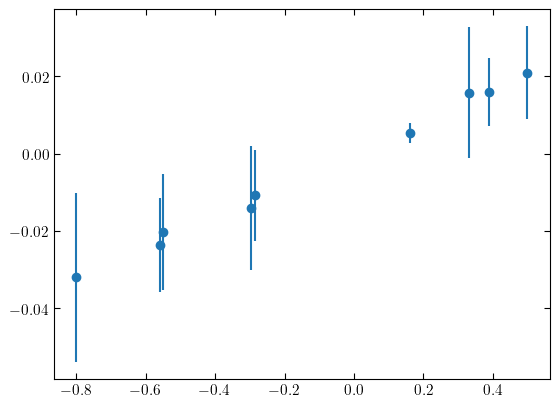

In [650]:
almost_zero_at_equal_mass = ['2.1.0', '3.3.0', '5.5.0']

if mode_string_pro in almost_zero_at_equal_mass:
    df_mode_3D_equal = df_mode_3D[df_mode_3D['eta'] > 0.249]
    plt.errorbar(df_mode_3D_equal['chi_m_orb'], np.sign(df_mode_3D_equal['chi_m_orb'])*df_mode_3D_equal['A_med_adj_temp'], yerr = 50*df_mode_3D_equal['A_range']*df_mode_3D_equal['A_med_adj_temp'], fmt=  'o')

0.040636447159328196


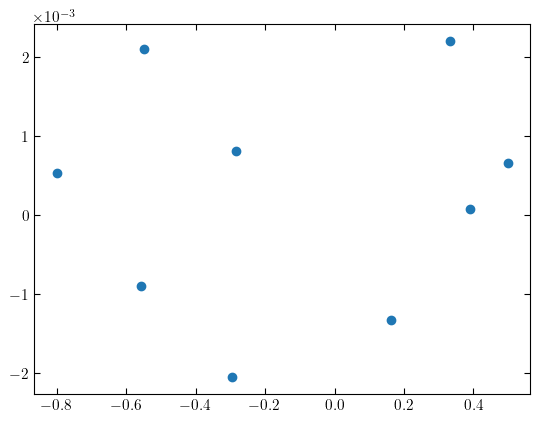

In [651]:
if mode_string_pro in almost_zero_at_equal_mass:

    w_eq_A = df_mode_3D_equal['A_range_adj_inv'].to_numpy()**2
    w_eq_A = w_eq_A/np.sum(w_eq_A)

    reg = LinearRegression(fit_intercept=False).fit(df_mode_3D_equal['chi_m_orb'].to_numpy().reshape(-1, 1), 
    np.sign(df_mode_3D_equal['chi_m_orb'])*df_mode_3D_equal['A_med_adj_temp'],
    sample_weight = w_eq_A)
    equal_chi_m_slope = reg.coef_[0]

    print(equal_chi_m_slope)

    df_mode_3D['A_med_adj'] = df_mode_3D['A_med_adj_temp'] - np.abs(reg.predict(df_mode_3D['chi_m_orb'].to_numpy().reshape(-1, 1)))
    df_mode_3D_full['A_med_adj'] = df_mode_3D_full['A_med_adj_temp'] - np.abs(reg.predict(df_mode_3D_full['chi_m_orb'].to_numpy().reshape(-1, 1)))

    df_mode_equal_zeroed = df_mode_3D[df_mode_3D['eta'] > 0.249]

    plt.scatter(df_mode_equal_zeroed['chi_m_orb'], np.sign(df_mode_equal_zeroed['chi_m_orb'])*df_mode_equal_zeroed['A_med_adj'])

In [652]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

row_r = 1/3.5

fig = make_subplots(
    rows=2, cols=3,
    specs=[[{'type': 'scene', 'colspan': 3}, None, None],
           [{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}], ],
    row_heights = [1-row_r, row_r],
    vertical_spacing= 0.05,
    horizontal_spacing= 0.085,
    # column_widths = 800,
    # row_heights = 800
    )

font1 = 24
font2 = 20
font3 = 16
balls1 = 25.0
balls2 = 15.0

df_plot = df_mode_3D_full_full

chi_p = df_plot['chi_p']
chi_m = df_plot['chi_m']
eta = df_plot['eta']
range_invs = ['A_range_inv', 'phi_range_inv', 'A_range_inv']

colorscales = ['Viridis', 'Viridis', 'inferno']
color_vars = ['A_med', 'phase_unwrapped', 't_flat_start']
color_bar_labels = [f'𝐴<sub>{mode_string_plot}</sub>', f'𝜙<sub>{mode_string_plot}</sub>', f'𝑡<sub>start</sub>/𝑀']
button_labels = [f'𝐴<sub>{mode_string_plot}</sub>', f'𝜙<sub>{mode_string_plot}</sub>', f'𝑡<sub>start</sub>']
visibles = [True] + (len(button_labels)-1)*[False]

for iii, color_var in enumerate(color_vars):

    fig1 = go.Scatter3d(x = chi_p, y = chi_m, z = eta, mode = 'markers',
                        marker = dict(size = df_plot[range_invs[iii]]**(1/3), sizeref = max(df_plot[range_invs[iii]])**(1/3)/balls1, 
                        color = df_plot[color_var], colorscale = colorscales[iii], showscale = True,
                        colorbar_x = 0.85,
                        colorbar_y = 2.6/4,
                        colorbar_len = 2.25/4,
                        colorbar_title = color_bar_labels[iii],
                        colorbar_titlefont = dict(size = font1)
                        ),
                        showlegend = False,
                        customdata = np.stack((df_plot['SXS_num'], df_plot['A_med'],
                                            df_plot['phase_unwrapped'], df_plot['A_range'], df_plot['phi_range'],
                                            df_plot['t_flat_start']), axis = -1),
                        hovertemplate = r'SXS:BBH:%{customdata[0]:04}<br>'
                                        r'<br>'
                                        r'𝐴: %{customdata[1]:.4e}<br>'
                                        r'𝜙: %{customdata[2]:.4f}<br>'
                                        r'𝛿𝐴: %{customdata[3]:.4e}<br>'
                                        r'𝛿𝜙 %{customdata[4]:.4e}<br>'
                                        r'𝑡<sub>start</sub>: %{customdata[5]:.1f} 𝑀<br>'
                                        r'<br>'
                                        r'𝜂: %{z:.4f}<br>'
                                        r'𝜒<sub>+</sub>: %{x:.4f}<br>'
                                        r'𝜒<sub>-</sub>: %{y:.4f}<extra></extra>',
                        visible = visibles[iii],
                        )

    small_marker_dict = dict(size = df_plot[range_invs[iii]]**(1/3), sizeref = max(df_plot[range_invs[iii]])**(1/3)/balls2,
                             color = df_plot[color_var], colorscale = colorscales[iii])

    fig2 = go.Scatter(x = chi_p, y = chi_m, mode = 'markers',
                        marker = small_marker_dict,
                        customdata = np.stack((df_plot['SXS_num'], df_plot['A_med'],
                                            df_plot['phase_unwrapped'], df_plot['A_range'], df_plot['phi_range'],
                                            df_plot['eta'], df_plot['t_flat_start']), axis = -1),
                        hovertemplate = r'SXS:BBH:%{customdata[0]:04}<br>'
                                        r'<br>'
                                        r'𝐴: %{customdata[1]:.4e}<br>'
                                        r'𝜙: %{customdata[2]:.4f}<br>'
                                        r'𝛿𝐴: %{customdata[3]:.4e}<br>'
                                        r'𝛿𝜙: %{customdata[4]:.4e}<br>'
                                        r'𝑡<sub>start</sub>: %{customdata[6]:.1f} 𝑀<br>'
                                        r'<br>'
                                        r'𝜂: %{customdata[5]:.4f}<br>'
                                        r'𝜒<sub>+</sub>: %{x:.4f}<br>'
                                        r'𝜒<sub>-</sub>: %{y:.4f}<extra></extra>',
                        visible = visibles[iii],
                        showlegend = False)

    fig3 = go.Scatter(x = chi_p, y = eta, mode = 'markers',
                        marker = small_marker_dict,
                        customdata = np.stack((df_plot['SXS_num'], df_plot['A_med'],
                                                df_plot['phase_unwrapped'], df_plot['A_range'], df_plot['phi_range'],
                                                df_plot['chi_m'], df_plot['t_flat_start']), axis = -1),
                        hovertemplate = r'SXS:BBH:%{customdata[0]:04}<br>'
                                        r'<br>'
                                        r'𝐴: %{customdata[1]:.4e}<br>'
                                        r'𝜙: %{customdata[2]:.4f}<br>'
                                        r'𝛿𝐴: %{customdata[3]:.4e}<br>'
                                        r'𝛿𝜙: %{customdata[4]:.4e}<br>'
                                        r'𝑡<sub>start</sub>: %{customdata[6]:.1f} 𝑀<br>'
                                        r'<br>'
                                        r'𝜂: %{y:.4f}<br>'
                                        r'𝜒<sub>+</sub>: %{x:.4f}<br>'
                                        r'𝜒<sub>-</sub>: %{customdata[5]:.4f}<extra></extra>',
                        visible = visibles[iii],
                        showlegend = False)

    fig4 = go.Scatter(x = chi_m, y = eta, mode = 'markers',
                        marker = small_marker_dict,
                        customdata = np.stack((df_plot['SXS_num'], df_plot['A_med'],
                                                df_plot['phase_unwrapped'], df_plot['A_range'], df_plot['phi_range'],
                                                df_plot['chi_p'], df_plot['t_flat_start']), axis = -1),
                        hovertemplate = r'SXS:BBH:%{customdata[0]:04}<br>'
                                        r'<br>'
                                        r'𝐴: %{customdata[1]:.4e}<br>'
                                        r'𝜙: %{customdata[2]:.4f}<br>'
                                        r'𝛿𝐴: %{customdata[3]:.4e}<br>'
                                        r'𝛿𝜙: %{customdata[4]:.4e}<br>'
                                        r'𝑡<sub>start</sub>: %{customdata[6]:.1f} 𝑀<br>'
                                        r'<br>'
                                        r'𝜂: %{y:.4f}<br>'
                                        r'𝜒<sub>+</sub>: %{customdata[5]:.4f}<br>'
                                        r'𝜒<sub>-</sub>: %{x:.4f}<extra></extra>',
                        visible = visibles[iii],
                        showlegend = False)

    fig.add_trace(fig1, row = 1, col = 1)
    fig.add_trace(fig2, row = 2, col = 1)
    fig.add_trace(fig3, row = 2, col = 2)
    fig.add_trace(fig4, row = 2, col = 3)

fig.update_layout(
        margin = dict(l=10, r=10, t=10, b=10),
        width = 700, height = 700,
        # coloraxis_colorbar_y = 0.5
        )

fig.update_layout(
        scene = dict(
            xaxis = dict(title = r'𝜒<sub>+</sub>', titlefont = dict(size=font1),
                         tick0 = -0.8, dtick = 0.2,
                         range = [-1.0, 1.0]),
            yaxis = dict(title = r'𝜒<sub>-</sub>', titlefont = dict(size=font1),
                         tick0 = -0.8, dtick = 0.2,
                         range = [-1.0, 1.0]),
            zaxis = dict(title = r'𝜂', titlefont = dict(size=font1),
                        tick0 = 0.1, dtick = 0.025, 
                        range = [0.09, 0.26]),
                    ),
        font_family = 'Geneva',
        xaxis1 = dict(title = r'𝜒<sub>+</sub>', titlefont = dict(size=font3),
                      tick0 = -1.0, dtick = 0.2,
                         range = [-1.0, 1.0]),
        yaxis1 = dict(title = r'𝜒<sub>-</sub>', titlefont = dict(size=font3),
                      tick0 = -1.0, dtick = 0.2,
                         range = [-1.0, 1.0]),
        xaxis2 = dict(title = r'𝜒<sub>+</sub>', titlefont = dict(size=font3),
                      tick0 = -1.0, dtick = 0.2,
                            range = [-1.0, 1.0]),
        yaxis2 = dict(title = r'𝜂', titlefont = dict(size=font3),
                      tick0 = 0.1, dtick = 0.025,
                            range = [0.09, 0.26],
                        title_standoff = 0),
        xaxis3 = dict(title = r'𝜒<sub>-</sub>', titlefont = dict(size=font3),
                        tick0 = -1.0, dtick = 0.2,
                        range = [-1.0, 1.0]),
        yaxis3 = dict(title = r'𝜂', titlefont = dict(size = font3),
                      tick0 = 0.1, dtick = 0.025,
                            range = [0.09, 0.26],
                            title_standoff = 0),)

zoomout = 1.5

camera = dict(
    eye = dict(x = 0.7*zoomout, y = -1.2*zoomout, z = 0.5*zoomout),
    center = dict(x = 0., y = 0, z = -0.1),
              )

fig.update_layout(scene_camera = camera)

config = {
  'toImageButtonOptions': {
    'format': 'jpeg', # one of png, svg, jpeg, webp
    # 'filename': 'custom_image',
    'scale': 15 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

buttons = []
for i, button_label in enumerate(button_labels):
    button_dict = dict(
        label = button_label,
        method = 'update',
        args = [{"visible": [0 <= j/4 - i < 1 for j in range(4*len(button_labels))]}],
    )
    buttons.append(button_dict)

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            font = dict(size = font2),
            borderwidth = 2,
            x=0.005,
            y=0.995,
            buttons=buttons,
            xanchor="left",
            yanchor="top",
            showactive=True,
            active = 0,
        )
    ]
)


fig.show(config = config)

fig.write_html(f'../../docs/mode_plots/plotly_{mode_string_pro}.html', full_html=False, include_plotlyjs='cdn')


In [653]:
if mode_string_pro in almost_zero_at_equal_mass:
    eta_cut = 0.245
    delta_adj = np.sqrt(1 - 4*df_mode_3D['eta'][df_mode_3D['eta']<eta_cut])
    delta_adj_all = np.sqrt(1 - 4*df_mode_3D['eta'])
    delta_adj_full = np.sqrt(1 - 4*df_mode_3D_full['eta'][df_mode_3D_full['eta']<eta_cut])
    delta_adj_full_all = np.sqrt(1 - 4*df_mode_3D_full['eta'])
else:
    eta_cut = 0.26
    delta_adj = np.ones(len(df_mode_3D['eta']))
    delta_adj_all = np.ones(len(df_mode_3D['eta']))
    delta_adj_full = np.ones(len(df_mode_3D_full['eta']))
    delta_adj_full_all = np.ones(len(df_mode_3D_full['eta']))

In [654]:
X_A = df_mode_3D[df_mode_3D['eta']<eta_cut][['eta', 'chi_p', 'chi_m']].to_numpy()
X_all_A = df_mode_3D[['eta', 'chi_p', 'chi_m']].to_numpy()
y_A = df_mode_3D[df_mode_3D['eta']<eta_cut]['A_med_adj'].to_numpy()/delta_adj
w_A = df_mode_3D[df_mode_3D['eta']<eta_cut]['A_range_adj_inv'].to_numpy()**2*delta_adj**2
w_A = w_A/np.sum(w_A)
X_phi = df_mode_3D[['eta', 'chi_p', 'chi_m']].to_numpy()
y_phi = df_mode_3D['phase_unwrapped'].to_numpy()
w_phi = df_mode_3D['phi_range_inv'].to_numpy()**2
w_phi = w_phi/np.sum(w_phi)

In [655]:
X_full_A = df_mode_3D_full[df_mode_3D_full['eta']<eta_cut][['eta', 'chi_p', 'chi_m']].to_numpy()
X_all_full_A = df_mode_3D_full[['eta', 'chi_p', 'chi_m']].to_numpy()
y_full_A = df_mode_3D_full[df_mode_3D_full['eta']<eta_cut]['A_med_adj'].to_numpy()/delta_adj_full
w_full_A = df_mode_3D_full[df_mode_3D_full['eta']<eta_cut]['A_range_adj_inv'].to_numpy()**2*delta_adj_full**2
w_full_A = w_full_A/np.sum(w_full_A)
X_full_phi = df_mode_3D_full[['eta', 'chi_p', 'chi_m']].to_numpy()
y_full_phi = df_mode_3D_full['phase_unwrapped'].to_numpy()
w_full_phi = df_mode_3D_full['phi_range_inv'].to_numpy()**2
w_full_phi = w_full_phi/np.sum(w_full_phi)

In [656]:
# train order by order and see how the loss changes for both training and validation set

v_loss_list_A = []
t_loss_list_A = []
full_loss_list_A = []
models_A = []
poly_features_list_A = []

degrees = list(range(1,7))
random_state=1234

for i in degrees:
    poly = PolynomialFeatures(degree=i, include_bias=False)
    poly_features_A = poly.fit_transform(X_A)
    poly_features_full_A = poly.fit_transform(X_full_A)
    poly_features_list_A.append(poly_features_A)

    X_t_A,X_v_A, y_t_A, y_v_A, w_t_A, w_v_A = train_test_split(poly_features_A,y_A,w_A,train_size=0.8,test_size=0.2,random_state=random_state)

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_t_A, y_t_A, sample_weight=w_t_A)
    models_A.append(poly_reg_model)

    v_loss = mse(y_v_A, poly_reg_model.predict(X_v_A), sample_weight=w_v_A)
    t_loss = mse(y_t_A, poly_reg_model.predict(X_t_A), sample_weight=w_t_A)
    full_loss = mse(y_full_A, poly_reg_model.predict(poly_features_full_A), sample_weight=w_full_A)
    v_loss_list_A.append(v_loss)
    t_loss_list_A.append(t_loss)
    full_loss_list_A.append(full_loss)

v_loss_list_A = np.array(v_loss_list_A)
best_indx_A = max(2, np.argmax(v_loss_list_A < np.min(v_loss_list_A*1.5)))

v_loss_list_phi = []
t_loss_list_phi = []
full_loss_list_phi = []
models_phi = []
poly_features_list_phi = []

degrees = list(range(1,7))
random_state=1234

for i in degrees:
    poly = PolynomialFeatures(degree=i, include_bias=False)
    poly_features_phi = poly.fit_transform(X_phi)
    poly_features_full_phi = poly.fit_transform(X_full_phi)
    poly_features_list_phi.append(poly_features_phi)

    X_t_phi,X_v_phi, y_t_phi, y_v_phi, w_t_phi, w_v_phi = train_test_split(poly_features_phi,y_phi,w_phi,train_size=0.8,test_size=0.2,random_state=random_state)

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_t_phi, y_t_phi, sample_weight=w_t_phi)
    models_phi.append(poly_reg_model)

    v_loss = mse(y_v_phi, poly_reg_model.predict(X_v_phi), sample_weight=w_v_phi)
    t_loss = mse(y_t_phi, poly_reg_model.predict(X_t_phi), sample_weight=w_t_phi)
    full_loss = mse(y_full_phi, poly_reg_model.predict(poly_features_full_phi), sample_weight=w_full_phi)
    v_loss_list_phi.append(v_loss)
    t_loss_list_phi.append(t_loss)
    full_loss_list_phi.append(full_loss)

v_loss_list_phi = np.array(v_loss_list_phi)
best_indx_phi = max(2, np.argmax(v_loss_list_phi < np.min(v_loss_list_phi*1.5)))

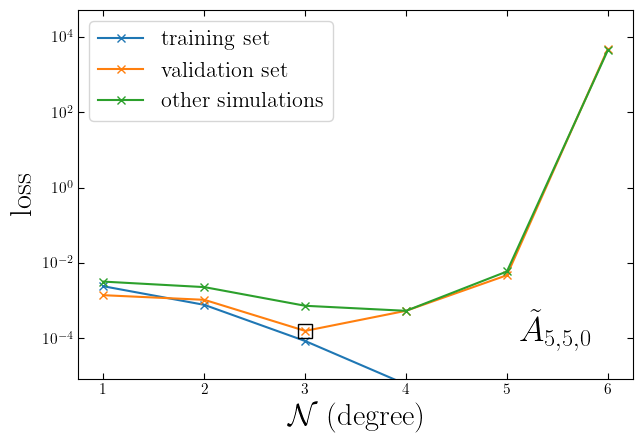

In [657]:
fig, ax = plt.subplots(figsize = (6.5, 4.5))

plot_to = 6

ax.semilogy(degrees[:plot_to], t_loss_list_A[:plot_to], label = 'training set', marker = 'x', c = 'C0')
ax.semilogy(degrees[:plot_to], v_loss_list_A[:plot_to], label = 'validation set', marker = 'x', c = 'C1')
ax.semilogy(degrees[:plot_to], full_loss_list_A[:plot_to], label = 'other simulations', marker = 'x', c = 'C2')

ax.plot(degrees[best_indx_A], v_loss_list_A[best_indx_A],
         marker = 's', markersize = 10, markerfacecolor = 'none', 
         markeredgewidth = 1, markeredgecolor = 'k')

ax.set_ylim(t_loss_list_A[best_indx_A]*0.1, None)

ax.set_xlabel('$\mathcal{N}$ (degree)', fontsize = 22)
ax.set_ylabel('loss', fontsize = 22)

ax.text(0.925, 0.075, f'$\\tilde{{A}}_{{{mode_string_plot_tex}}}$', fontsize=25, transform=ax.transAxes,
        horizontalalignment='right', verticalalignment='bottom')

ax.legend(fontsize = 16)

fig.tight_layout()
# plt.show()
plt.savefig(f'../../plots/loss_vs_degree_A_{mode_string_pro}.pdf')

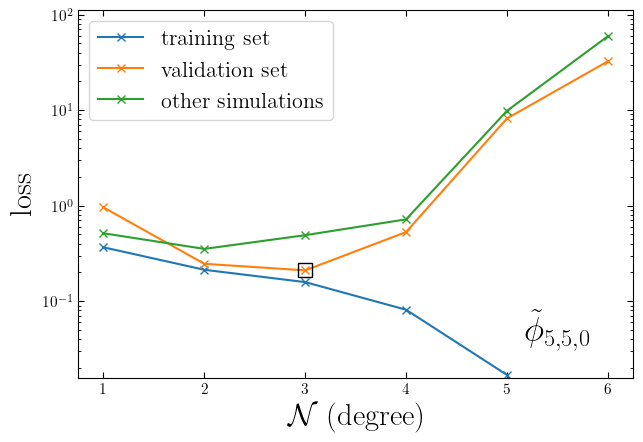

In [658]:
fig, ax = plt.subplots(figsize = (6.5, 4.5))

plot_to = 6

ax.semilogy(degrees[:plot_to], t_loss_list_phi[:plot_to], label = 'training set', marker = 'x', c = 'C0')
ax.semilogy(degrees[:plot_to], v_loss_list_phi[:plot_to], label = 'validation set', marker = 'x', c = 'C1')
ax.semilogy(degrees[:plot_to], full_loss_list_phi[:plot_to], label = 'other simulations', marker = 'x', c = 'C2')

ax.plot(degrees[best_indx_phi], v_loss_list_phi[best_indx_phi],
         marker = 's', markersize = 10, markerfacecolor = 'none', 
         markeredgewidth = 1, markeredgecolor = 'k')

ax.set_ylim(t_loss_list_phi[best_indx_phi]*0.1, None)

ax.set_xlabel('$\mathcal{N}$ (degree)', fontsize = 22)
ax.set_ylabel('loss', fontsize = 22)

ax.text(0.925, 0.075, f'$\\tilde{{\phi}}_{{{mode_string_plot_tex}}}$', fontsize=25, transform=ax.transAxes,
        horizontalalignment='right', verticalalignment='bottom')

ax.legend(fontsize = 16)

fig.tight_layout()
plt.savefig(f'../../plots/loss_vs_degree_phi_{mode_string_pro}.pdf')

In [659]:
if mode_string_pro in ['2.1.1']:
    best_degree_A = 4
elif mode_string_pro in ['3.2.0', '4.4.0']:
    best_degree_A = 5
# elif mode_string_pro in ['5.5.0']:
#     best_degree_A = 6
# elif mode_string_pro in ['-2.2.0']:
#     best_degree_A = 5
else:
    best_degree_A = degrees[best_indx_A]

poly_A = PolynomialFeatures(degree=best_degree_A, include_bias=True)
poly_features_A = poly_A.fit_transform(X_A)
poly_features_A_all = poly_A.fit_transform(X_all_A)
poly_features_full_A = poly_A.fit_transform(X_full_A)
poly_features_full_A_all = poly_A.fit_transform(X_all_full_A)
X_t_A,X_v_A, y_t_A, y_v_A, w_t_A, w_v_A = train_test_split(poly_features_A,y_A,w_A,train_size=0.8,test_size=0.2,random_state=random_state)

length = X_t_A.shape[1]
X_t_copy = X_t_A.copy()
X_v_copy = X_v_A.copy()
X_full_copy = poly_features_full_A.copy()
del_indx_list_A = []
del_loss_list_A = [t_loss_list_A[best_indx_A]]
del_v_loss_list_A = [v_loss_list_A[best_indx_A]]
del_extra_v_loss_list_A = [full_loss_list_A[best_indx_A]]
for j in range(len(X_t_A[0])-1):
    del_indx = 1
    best_loss = np.inf
    for i in range(len(X_t_copy[0])):
        if i == 0:
            continue
        X_t_del = np.delete(X_t_copy, i, 1)
        X_v_del = np.delete(X_v_copy, i, 1)
        X_full_dell = np.delete(X_full_copy, i, 1)
        poly_reg_model_del = LinearRegression(fit_intercept = False)
        poly_reg_model_del.fit(X_t_del, y_t_A, sample_weight=w_t_A)
        loss = mse(y_t_A, poly_reg_model_del.predict(X_t_del), sample_weight=w_t_A)
        v_loss = mse(y_v_A, poly_reg_model_del.predict(X_v_del), sample_weight=w_v_A)
        extra_v_loss = mse(y_full_A, poly_reg_model_del.predict(X_full_dell), sample_weight=w_full_A)
        if loss < best_loss:
            best_loss = loss
            del_indx = i
    X_t_copy = np.delete(X_t_copy, del_indx, 1)
    X_v_copy = np.delete(X_v_copy, del_indx, 1)
    X_full_copy = np.delete(X_full_copy, del_indx, 1)
    del_indx_list_A.append(del_indx)
    del_loss_list_A.append(best_loss)
    del_v_loss_list_A.append(v_loss)
    del_extra_v_loss_list_A.append(extra_v_loss)

loss_list_order_A = del_loss_list_A[::-1]
v_loss_list_order_A = del_v_loss_list_A[::-1]
extra_v_loss_list_order_A = del_extra_v_loss_list_A[::-1]

In [660]:
x_points_A = (np.array(range(len(X_t_A[0]))) + 1)
v_loss_min_A = np.min(v_loss_list_order_A[:20])
best_term_indx_A = np.argmax(v_loss_list_order_A < v_loss_min_A*1.5)
best_term_num_A = x_points_A[best_term_indx_A]

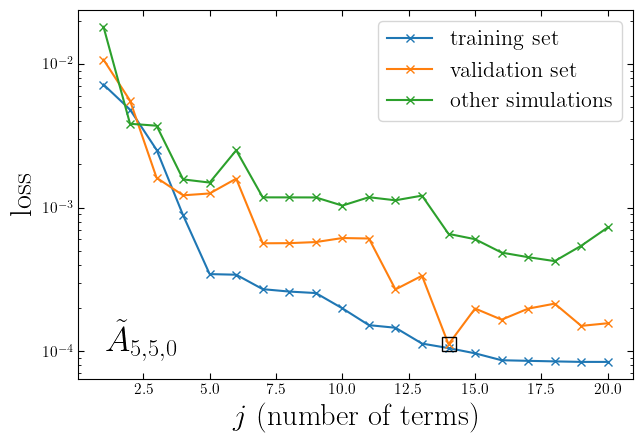

In [661]:
fig, ax = plt.subplots(figsize = (6.5, 4.5))

ax.semilogy(x_points_A, loss_list_order_A, label='training set', marker = 'x')
ax.semilogy(x_points_A, v_loss_list_order_A, label='validation set', marker = 'x')
ax.semilogy(x_points_A, extra_v_loss_list_order_A, label='other simulations', marker = 'x')
ax.plot(best_term_num_A, v_loss_list_order_A[best_term_indx_A], marker = 's', markersize = 10, markerfacecolor = 'none',
            markeredgewidth = 1, markeredgecolor = 'k')

ax.legend(fontsize = 16)
ax.set_xlabel('$j$ (number of terms)', fontsize = 22)
ax.set_ylabel('loss', fontsize = 22)

ax.text(0.05, 0.075, f'$\\tilde{{A}}_{{{mode_string_plot_tex}}}$', fontsize=25, transform=ax.transAxes)

fig.tight_layout()
plt.savefig(f'../../plots/loss_vs_n_terms_A_{mode_string_pro}.pdf')

In [662]:
if mode_string_pro in ['4.4.0']:
    best_degree_phi = 6
elif mode_string_pro in ['5.5.0']:
    best_degree_phi = 6
else:
    best_degree_phi = degrees[best_indx_phi]

poly_phi = PolynomialFeatures(degree=best_degree_phi, include_bias=True)
poly_features_phi = poly_phi.fit_transform(X_phi)
poly_features_full_phi = poly_phi.fit_transform(X_full_phi)
X_t_phi,X_v_phi, y_t_phi, y_v_phi, w_t_phi, w_v_phi = train_test_split(poly_features_phi,y_phi,w_phi,train_size=0.8,test_size=0.2,random_state=random_state)

length = X_t_phi.shape[1]
X_t_copy = X_t_phi.copy()
X_v_copy = X_v_phi.copy()
X_full_copy = poly_features_full_phi.copy()
del_indx_list_phi = []
del_loss_list_phi = [t_loss_list_phi[best_indx_phi]]
del_v_loss_list_phi = [v_loss_list_phi[best_indx_phi]]
del_extra_v_loss_list_phi = [full_loss_list_phi[best_indx_phi]]
for j in range(len(X_t_phi[0])-1):
    del_indx = 1
    best_loss = np.inf
    for i in range(len(X_t_copy[0])):
        if i == 0:
            continue
        X_t_del = np.delete(X_t_copy, i, 1)
        X_v_del = np.delete(X_v_copy, i, 1)
        X_full_dell = np.delete(X_full_copy, i, 1)
        poly_reg_model_del = LinearRegression(fit_intercept = False)
        poly_reg_model_del.fit(X_t_del, y_t_phi, sample_weight=w_t_phi)
        loss = mse(y_t_phi, poly_reg_model_del.predict(X_t_del), sample_weight=w_t_phi)
        v_loss = mse(y_v_phi, poly_reg_model_del.predict(X_v_del), sample_weight=w_v_phi)
        extra_v_loss = mse(y_full_phi, poly_reg_model_del.predict(X_full_dell), sample_weight=w_full_phi)
        if loss < best_loss:
            best_loss = loss
            del_indx = i
    X_t_copy = np.delete(X_t_copy, del_indx, 1)
    X_v_copy = np.delete(X_v_copy, del_indx, 1)
    X_full_copy = np.delete(X_full_copy, del_indx, 1)
    del_indx_list_phi.append(del_indx)
    del_loss_list_phi.append(best_loss)
    del_v_loss_list_phi.append(v_loss)
    del_extra_v_loss_list_phi.append(extra_v_loss)

loss_list_order_phi = del_loss_list_phi[::-1]
v_loss_list_order_phi = del_v_loss_list_phi[::-1]
extra_v_loss_list_order_phi = del_extra_v_loss_list_phi[::-1]

In [663]:
x_points_phi = (np.array(range(len(X_t_phi[0]))) + 1)
v_loss_min_phi = np.min(v_loss_list_order_phi[:20])
best_term_indx_phi = np.argmax(v_loss_list_order_phi < v_loss_min_phi*1.5)
best_term_num_phi = x_points_phi[best_term_indx_phi]

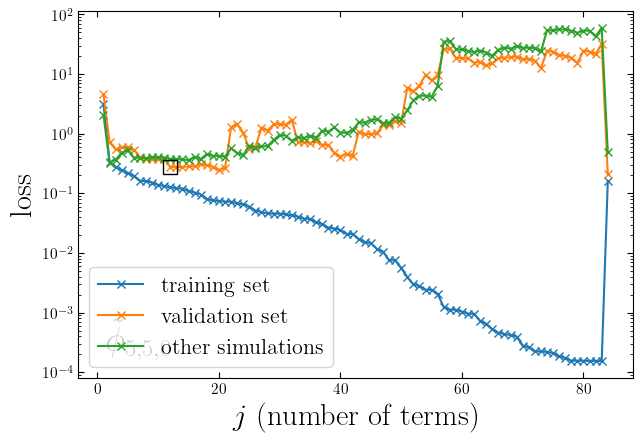

In [664]:
fig, ax = plt.subplots(figsize = (6.5, 4.5))

ax.semilogy(x_points_phi, loss_list_order_phi, label='training set', marker = 'x')
ax.semilogy(x_points_phi, v_loss_list_order_phi, label='validation set', marker = 'x')
ax.semilogy(x_points_phi, extra_v_loss_list_order_phi, label='other simulations', marker = 'x')
ax.plot(best_term_num_phi, v_loss_list_order_phi[best_term_indx_phi], marker = 's', markersize = 10, markerfacecolor = 'none',
            markeredgewidth = 1, markeredgecolor = 'k')

ax.legend(fontsize = 16)
ax.set_xlabel('$j$ (number of terms)', fontsize = 22)
ax.set_ylabel('loss', fontsize = 22)

ax.text(0.05, 0.075, f'$\\tilde{{\phi}}_{{{mode_string_plot_tex}}}$', fontsize=25, transform=ax.transAxes)

fig.tight_layout()
plt.savefig(f'../../plots/loss_vs_n_terms_phi_{mode_string_pro}.pdf')

In [665]:
indx_list_A = list(range(len(poly_features_A[0])))
original_indx_del_list_A = []
for indx in del_indx_list_A:
    original_indx_del_list_A.append(indx_list_A[indx])
    del indx_list_A[indx]
original_indx_del_list_A.append(indx_list_A[0])
original_indx_order_A = original_indx_del_list_A[::-1]
include_terms_A = original_indx_order_A[:best_term_num_A]
include_terms_sorted_A = np.sort(include_terms_A)
X_t_red_A = X_t_A[:,include_terms_sorted_A]
X_v_red_A = X_v_A[:,include_terms_sorted_A]
poly_red_A = LinearRegression()
poly_red_A.fit(X_t_red_A, y_t_A, sample_weight=w_t_A)

LinearRegression()

In [666]:
indx_list_phi = list(range(len(poly_features_phi[0])))
original_indx_del_list_phi = []
for indx in del_indx_list_phi:
    original_indx_del_list_phi.append(indx_list_phi[indx])
    del indx_list_phi[indx]
original_indx_del_list_phi.append(indx_list_phi[0])
original_indx_order_phi = original_indx_del_list_phi[::-1]
include_terms_phi = original_indx_order_phi[:best_term_num_phi]
include_terms_sorted_phi = np.sort(include_terms_phi)
X_t_red_phi = X_t_phi[:,include_terms_sorted_phi]
X_v_red_phi = X_v_phi[:,include_terms_sorted_phi]
poly_red_phi = LinearRegression()
poly_red_phi.fit(X_t_red_phi, y_t_phi, sample_weight=w_t_phi)

LinearRegression()

In [667]:
def to_sigfig(num, sigfig = 4):
    return np.format_float_positional(num, precision=sigfig, fractional = False, trim = '-')

In [668]:
def poly_expression_latex(powers, poly_red, variables = ['\eta', '\chi_+', '\chi_-'], sigfig = 4, real = False):
    save_array = []
    complex_intercept = poly_red.intercept_
    save_array.append([0, 0, 0, poly_red.intercept_])
    intercept_A = np.abs(complex_intercept)
    intercept_phi = np.angle(complex_intercept)
    if intercept_phi < 0:
        intercept_phi += 2*np.pi
    if real:
        if 3*np.pi/2 > intercept_phi > np.pi/2:
            expression = f'- {to_sigfig(intercept_A, sigfig = sigfig)}'
        else:
            expression = f'{to_sigfig(intercept_A, sigfig = sigfig)}'
    else:
        expression = f'{to_sigfig(intercept_A, sigfig = sigfig)} e^{{i {to_sigfig(intercept_phi, sigfig = sigfig)}}}'
    for p, power in enumerate(powers):
        if np.all(power == 0):
            continue
        complex_coeff = poly_red.coef_[p]
        save_array.append([power[0], power[1], power[2], poly_red.coef_[p]])
        coeff_A = np.abs(complex_coeff)
        coeff_phi = np.angle(complex_coeff)
        if coeff_phi < 0:
            coeff_phi += 2*np.pi
        if real:
            if 3*np.pi/2 > coeff_phi > np.pi/2:
                coef_expression = f' - {to_sigfig(coeff_A, sigfig = sigfig)}'
            else:
                coef_expression = f' + {to_sigfig(coeff_A, sigfig = sigfig)}'
        else:
            coef_expression = f' + {to_sigfig(coeff_A, sigfig = sigfig)} e^{{i {to_sigfig(coeff_phi, sigfig = sigfig)}}}'
        expression += coef_expression
        for i in range(len(power)):
            if power[i] == 0:
                continue
            if power[i] == 1:
                expression += f' {variables[i]}'
            else:
                expression += f' {variables[i]}^{power[i]}'
    save_array = np.array(save_array)
    return expression, save_array

In [669]:
from IPython.display import display, Math

In [670]:
tex_expression_A, save_array_A = poly_expression_latex(poly_A.powers_[include_terms_sorted_A], poly_red_A, real = True)
display(Math(tex_expression_A))

<IPython.core.display.Math object>

In [671]:
tex_expression_phi, save_array_phi = poly_expression_latex(poly_phi.powers_[include_terms_sorted_phi], poly_red_phi, real = True)
display(Math(tex_expression_phi))

<IPython.core.display.Math object>

In [672]:
if mode_string_pro in almost_zero_at_equal_mass:
    save_array_A_out = np.vstack([save_array_A, np.array([[np.nan, np.nan, 1., equal_chi_m_slope]])])
else:
    save_array_A_out = save_array_A

In [673]:
with open(f'./fit_expressions/hyperfit_tex_A_{mode_string_pro}.txt', 'w') as f:
    f.write(tex_expression_A)
    if mode_string_pro in almost_zero_at_equal_mass:
        f.write('\nequal mass adjustment:\n')
        f.write(f'{to_sigfig(np.abs(equal_chi_m_slope), 4)}' + r' |\chi_-|')

np.savetxt(f'./fit_expressions/hyperfit_array_A_{mode_string_pro}.csv', save_array_A_out)

with open(f'./fit_expressions/hyperfit_tex_phi_{mode_string_pro}.txt', 'w') as f:
    f.write(tex_expression_phi)

np.savetxt(f'./fit_expressions/hyperfit_array_phi_{mode_string_pro}.csv', save_array_phi)

In [674]:
# y_pred = models[best_indx].predict(poly_features_list[best_indx])
A_pred = poly_red_A.predict(poly_features_A_all[:, include_terms_sorted_A])
A_pred_full = poly_red_A.predict(poly_features_full_A_all[:, include_terms_sorted_A])
phi_pred = poly_red_phi.predict(poly_features_phi[:, include_terms_sorted_phi])
phi_pred_full = poly_red_phi.predict(poly_features_full_phi[:, include_terms_sorted_phi])

In [675]:
if mode_string_pro in almost_zero_at_equal_mass:
    df_mode_3D['A_pred'] = (A_pred*delta_adj_all + equal_chi_m_slope*np.abs(df_mode_3D['chi_m']))*PN_func(df_mode_3D['eta'])
else:
    df_mode_3D['A_pred'] = A_pred*PN_func(df_mode_3D['eta'])
df_mode_3D['A_pred_err'] = np.abs(df_mode_3D['A_pred'] - df_mode_3D['A_med'])
df_mode_3D['A_pred_rel_err'] = np.abs(df_mode_3D['A_pred_err']/df_mode_3D['A_med'])
df_mode_3D['phi_pred'] = phi_pred
df_mode_3D['phi_pred_err'] = np.abs(df_mode_3D['phi_pred'] - df_mode_3D['phase_unwrapped'])
df_mode_3D['phi_pred_rel_err'] = np.abs(df_mode_3D['phi_pred_err']/df_mode_3D['phase_unwrapped'])

In [676]:
if mode_string_pro in almost_zero_at_equal_mass:
    df_mode_3D_full['A_pred'] = (A_pred_full*delta_adj_full_all + equal_chi_m_slope*np.abs(df_mode_3D_full['chi_m']))*PN_func(df_mode_3D_full['eta'])
else:
    df_mode_3D_full['A_pred'] = A_pred_full*PN_func(df_mode_3D_full['eta'])
df_mode_3D_full['A_pred_err'] = np.abs(df_mode_3D_full['A_pred'] - df_mode_3D_full['A_med'])
df_mode_3D_full['A_pred_rel_err'] = np.abs(df_mode_3D_full['A_pred_err']/df_mode_3D_full['A_med'])
df_mode_3D_full['phi_pred'] = phi_pred_full
df_mode_3D_full['phi_pred_err'] = np.abs(df_mode_3D_full['phi_pred'] - df_mode_3D_full['phase_unwrapped'])
df_mode_3D_full['phi_pred_rel_err'] = np.abs(df_mode_3D_full['phi_pred_err']/df_mode_3D_full['phase_unwrapped'])

In [677]:
df_mode_3D_copy_A = df_mode_3D.copy()
df_mode_3D_copy_A.sort_values('A_med', ascending = True, inplace = True)
df_mode_3D_copy_phi = df_mode_3D.copy()
df_mode_3D_copy_phi.sort_values('phase_unwrapped', ascending = True, inplace = True)

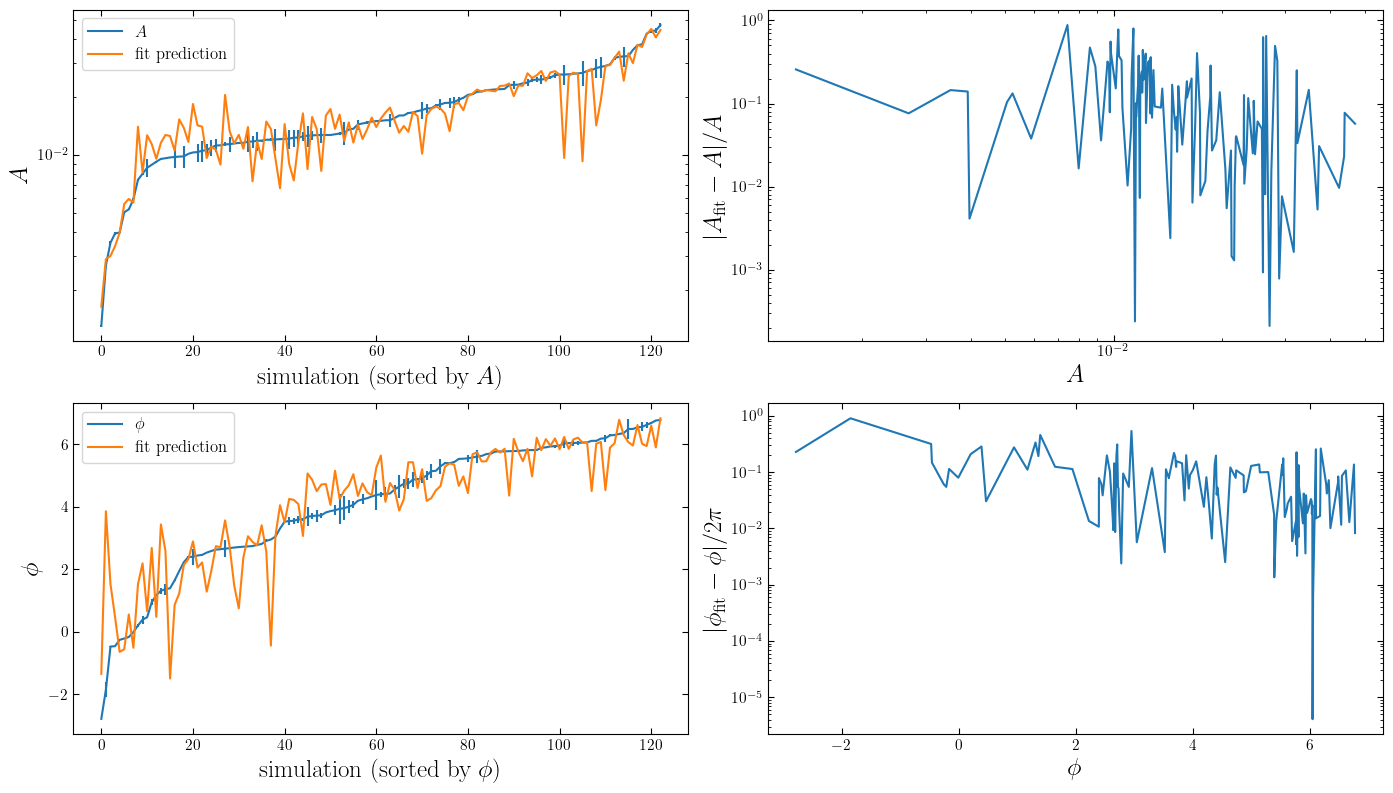

In [678]:
fig, axss = plt.subplots(2, 2, figsize = (14, 8))

axs = axss[0]

axs[0].semilogy(df_mode_3D_copy_A['A_med'].to_numpy(), label = r'$A$')
axs[0].errorbar(range(len(df_mode_3D_copy_A)), df_mode_3D_copy_A['A_med'].to_numpy(), 
             yerr = df_mode_3D_copy_A['A_med'].to_numpy()*df_mode_3D_copy_A['A_range'].to_numpy(), fmt = 'none',
             )
axs[0].semilogy(df_mode_3D_copy_A['A_pred'].to_numpy(), label = r'fit prediction')
axs[0].set_xlabel(r'simulation (sorted by $A$)')
axs[0].set_ylabel(r'$A$')
axs[0].legend()

axs[1].loglog(df_mode_3D_copy_A['A_med'].to_numpy(), np.abs(df_mode_3D_copy_A['A_med'].to_numpy() - df_mode_3D_copy_A['A_pred'].to_numpy())/df_mode_3D_copy_A['A_med'].to_numpy())
axs[1].set_xlabel(r'$A$')
axs[1].set_ylabel(r'$|A_{\rm fit} - A|/A$')

axs = axss[1]

axs[0].plot(df_mode_3D_copy_phi['phase_unwrapped'].to_numpy(), label = r'$\phi$')
axs[0].errorbar(range(len(df_mode_3D_copy_phi)), df_mode_3D_copy_phi['phase_unwrapped'].to_numpy(), 
             yerr = df_mode_3D_copy_phi['phi_range'].to_numpy(), fmt = 'none',
             )
axs[0].plot(df_mode_3D_copy_phi['phi_pred'].to_numpy(), label = r'fit prediction')
axs[0].set_xlabel(r'simulation (sorted by $\phi$)')
axs[0].set_ylabel(r'$\phi$')
axs[0].legend()

axs[1].semilogy(df_mode_3D_copy_phi['phase_unwrapped'].to_numpy(), np.abs(df_mode_3D_copy_phi['phase_unwrapped'].to_numpy() - df_mode_3D_copy_phi['phi_pred'].to_numpy())/(2*np.pi))
axs[1].set_xlabel(r'$\phi$')
axs[1].set_ylabel(r'$|\phi_{\rm fit} - \phi|/2\pi$')



fig.tight_layout()
plt.savefig(f'../../plots/fit_err_{mode_string_pro}.pdf')
plt.savefig(f'../../plots/fit_err_{mode_string_pro}.png', dpi = 300, bbox_inches = 'tight', transparent = False, facecolor='white')

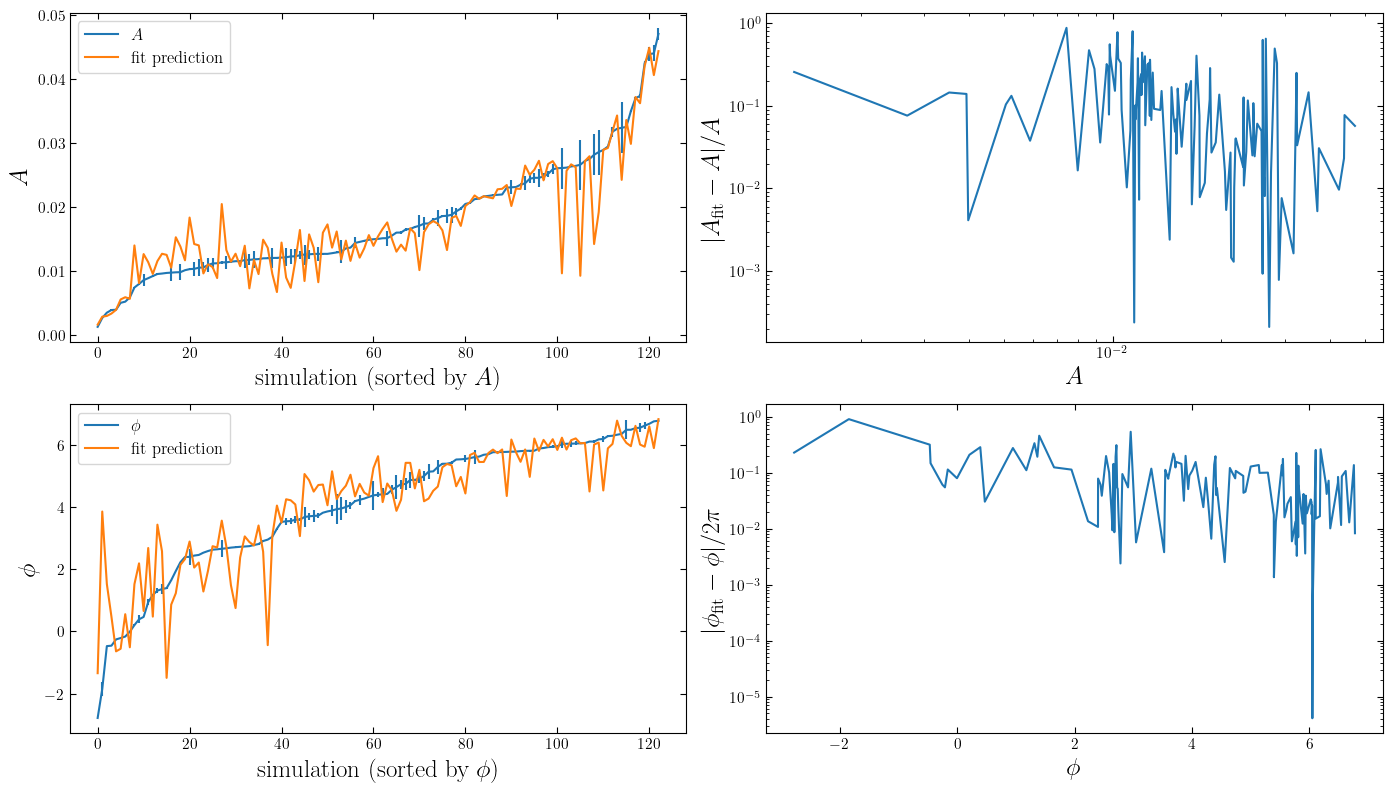

In [679]:
fig, axss = plt.subplots(2, 2, figsize = (14, 8))

axs = axss[0]

axs[0].plot(df_mode_3D_copy_A['A_med'].to_numpy(), label = r'$A$')
axs[0].errorbar(range(len(df_mode_3D_copy_A)), df_mode_3D_copy_A['A_med'].to_numpy(), 
             yerr = df_mode_3D_copy_A['A_med'].to_numpy()*df_mode_3D_copy_A['A_range'].to_numpy(), fmt = 'none',
             )
axs[0].plot(df_mode_3D_copy_A['A_pred'].to_numpy(), label = r'fit prediction')
axs[0].set_xlabel(r'simulation (sorted by $A$)')
axs[0].set_ylabel(r'$A$')
axs[0].legend()

axs[1].loglog(df_mode_3D_copy_A['A_med'].to_numpy(), np.abs(df_mode_3D_copy_A['A_med'].to_numpy() - df_mode_3D_copy_A['A_pred'].to_numpy())/df_mode_3D_copy_A['A_med'].to_numpy())
axs[1].set_xlabel(r'$A$')
axs[1].set_ylabel(r'$|A_{\rm fit} - A|/A$')

axs = axss[1]

axs[0].plot(df_mode_3D_copy_phi['phase_unwrapped'].to_numpy(), label = r'$\phi$')
axs[0].errorbar(range(len(df_mode_3D_copy_phi)), df_mode_3D_copy_phi['phase_unwrapped'].to_numpy(), 
             yerr = df_mode_3D_copy_phi['phi_range'].to_numpy(), fmt = 'none',
             )
axs[0].plot(df_mode_3D_copy_phi['phi_pred'].to_numpy(), label = r'fit prediction')
axs[0].set_xlabel(r'simulation (sorted by $\phi$)')
axs[0].set_ylabel(r'$\phi$')
axs[0].legend()

axs[1].semilogy(df_mode_3D_copy_phi['phase_unwrapped'].to_numpy(), np.abs(df_mode_3D_copy_phi['phase_unwrapped'].to_numpy() - df_mode_3D_copy_phi['phi_pred'].to_numpy())/(2*np.pi))
axs[1].set_xlabel(r'$\phi$')
axs[1].set_ylabel(r'$|\phi_{\rm fit} - \phi|/2\pi$')



fig.tight_layout()

In [1102]:
# fig, axs = plt.subplots(1, 2, figsize = (14, 4))

# axs[0].semilogy(df_mode_3D_copy_A['A_med'].to_numpy(), label = r'$A$')
# axs[0].errorbar(range(len(df_mode_3D_copy_A)), df_mode_3D_copy_A['A_med'].to_numpy(), 
#              yerr = df_mode_3D_copy_A['A_med'].to_numpy()*df_mode_3D_copy_A['A_range'].to_numpy(), fmt = 'none',
#              )
# axs[0].semilogy(df_mode_3D_copy_A['A_pred'].to_numpy(), label = r'fit prediction')
# axs[0].set_xlabel(r'simulation (sorted by $A$)')
# axs[0].set_ylabel(r'$A$')
# axs[0].legend()

# axs[1].loglog(df_mode_3D_copy_A['A_med'].to_numpy(), np.abs(df_mode_3D_copy_A['A_med'].to_numpy() - df_mode_3D_copy_A['A_pred'].to_numpy())/df_mode_3D_copy_A['A_med'].to_numpy())
# axs[1].set_xlabel(r'$A$')
# axs[1].set_ylabel(r'$|A_{\rm fit} - A|/A$')


# fig.tight_layout()
# plt.savefig(f'../../plots/fit_err_{mode_string_pro}.pdf')
# plt.savefig(f'../../plots/fit_err_{mode_string_pro}.png', dpi = 300, bbox_inches = 'tight', transparent = False, facecolor='white')